# Training Data 

Settled on the approach of combining the  two primary data sources first and then performing preprocessing on the 

combined dataset.The two primary data sources will be the training data


In [359]:
#modules/libraries 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import spacy
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
import string
import gensim
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora
import wordcloud
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from nltk import ngrams, word_tokenize
from collections import Counter



nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## OCHA DATA

OCHA SERVICES DATA: This dataset is a detailed dataset containing data regarding the many different services and 

amenities available in Kenya, and the date when they were recorded. We will use this data in training our model to 

identify the specific service or amenity a resident wants improved. Below is the link to the dataset:

In [360]:
#ocha dataset
ocha_dataset=pd.read_csv("infrastructure_ken.csv")
ocha_dataset.head(10)

,Country Name,Country ISO3,Year,Indicator Name,Indicator Code,Value
0,#country+name,#country+code,#date+year,#indicator+name,#indicator+code,#indicator+value+num
1,Kenya,KEN,2021,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,973328921.924682
2,Kenya,KEN,2020,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,567129881.228679
3,Kenya,KEN,2019,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,628827610.941533
4,Kenya,KEN,2018,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,570245522.266492
5,Kenya,KEN,2017,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,473090014.312925
6,Kenya,KEN,2016,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,451360165.698429
7,Kenya,KEN,2015,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,550307434.561937
8,Kenya,KEN,2014,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,755711724.114998
9,Kenya,KEN,2013,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,515175648.649776


In [361]:
ocha_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country Name    1340 non-null   object
 1   Country ISO3    1340 non-null   object
 2   Year            1340 non-null   object
 3   Indicator Name  1340 non-null   object
 4   Indicator Code  1340 non-null   object
 5   Value           1340 non-null   object
dtypes: object(6)
memory usage: 62.9+ KB


In [362]:
ocha_dataset.columns

Index(['Country Name', 'Country ISO3', 'Year', 'Indicator Name',
       'Indicator Code', 'Value'],
      dtype='object')

In [363]:
ocha_dataset.drop(0, inplace=True)
ocha_dataset.head()

,Country Name,Country ISO3,Year,Indicator Name,Indicator Code,Value
1,Kenya,KEN,2021,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,973328921.924682
2,Kenya,KEN,2020,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,567129881.228679
3,Kenya,KEN,2019,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,628827610.941533
4,Kenya,KEN,2018,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,570245522.266492
5,Kenya,KEN,2017,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,473090014.312925


In [364]:
#total number of services per year
year_counts=ocha_dataset['Year'].value_counts()
year_counts

Year
2009    45
2008    44
2007    42
2004    42
2010    41
        ..
1964     2
1963     2
1962     2
1961     2
1960     2
Name: count, Length: 63, dtype: int64

In [365]:
# Get the most common service across all years
most_common_activity = ocha_dataset['Indicator Name'].mode()[0]
most_common_activity

'Renewable internal freshwater resources per capita (cubic meters)'

In [366]:
# Group the data by 'Year' and find the most common services for each year
most_common_activities = ocha_dataset.groupby('Year')['Indicator Name'].agg(lambda x: x.mode().iloc[0]).reset_index()
most_common_activities.head(10)#early sixities services

,Year,Indicator Name
0,1960,Mobile cellular subscriptions
1,1961,Renewable internal freshwater resources per ca...
2,1962,Renewable internal freshwater resources per ca...
3,1963,Renewable internal freshwater resources per ca...
4,1964,Renewable internal freshwater resources per ca...
5,1965,Fixed telephone subscriptions
6,1966,Fixed telephone subscriptions
7,1967,Fixed telephone subscriptions
8,1968,Fixed telephone subscriptions
9,1969,Fixed telephone subscriptions


In [367]:
#Most Common activities in the past 10 years
most_common_activities.tail(10)

,Year,Indicator Name
53,2013,"Air transport, freight (million ton-km)"
54,2014,"Air transport, freight (million ton-km)"
55,2015,"Air transport, freight (million ton-km)"
56,2016,"Air transport, freight (million ton-km)"
57,2017,"Air transport, freight (million ton-km)"
58,2018,"Air transport, freight (million ton-km)"
59,2019,"Air transport, freight (million ton-km)"
60,2020,"Air transport, freight (million ton-km)"
61,2021,"Air transport, freight (million ton-km)"
62,2022,Fixed broadband subscriptions


Plotting  Graph for the most common services provided in the last 10 years

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

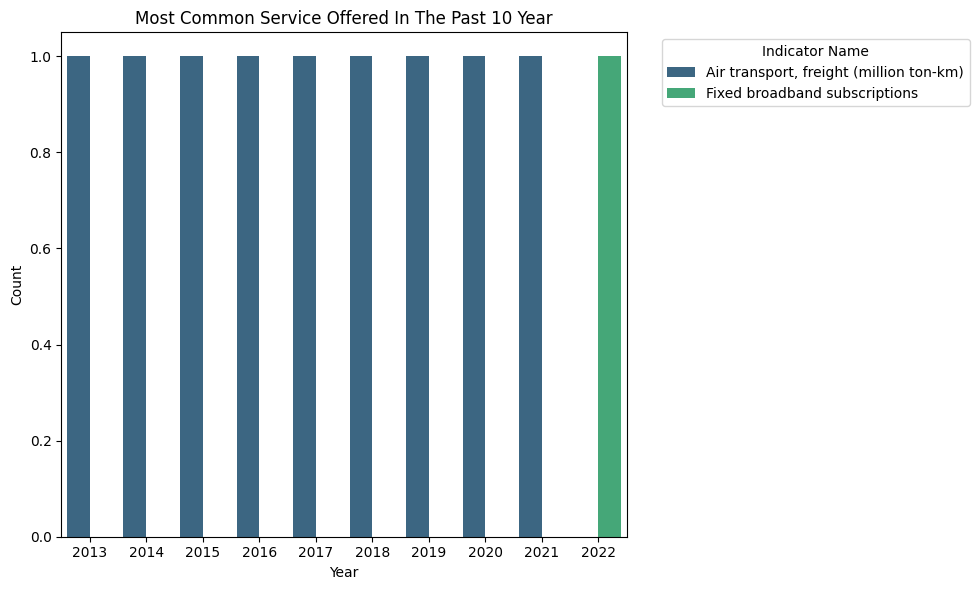

In [368]:
plt.figure(figsize=(10, 6))
sns.countplot(data=most_common_activities.tail(10), x='Year', hue='Indicator Name', palette='viridis', dodge=True)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Most Common Service Offered In The Past 10 Year')
plt.legend(title='Indicator Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [369]:
#statistical representation of the years in which the data was recoreded
ocha_dataset['Year']=pd.to_numeric(ocha_dataset['Year'],errors='coerce')
years=ocha_dataset['Year']
describe_stats=years.describe()
describe_stats

count    1339.000000
mean     1999.887229
std        14.007685
min      1960.000000
25%      1991.000000
50%      2002.000000
75%      2010.000000
max      2022.000000
Name: Year, dtype: float64

Data Pre-processing

In [370]:
#make copy of original dataset
ocha_clean=ocha_dataset.copy()

In [371]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [372]:
import spacy
# Load the English language model for spaCy
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Function for expanding contractions
    # Regular expression for finding contractions
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    
    def expand_contractions(text, contractions_dict=contractions_dict):
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    def remove_stopwords(article):
        article_tokens = word_tokenize(article)
        filtered_article = [word for word in article_tokens if not word in stop_words]
        return " ".join(filtered_article)
    
    # Remove punctuations and digits
    def clean_text(text):
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\d+', '', text)
        return text
    
      
        
    # Convert text to lowercase
    def convert_to_lower(text):
        return text.lower()
    
    # Remove words with fewer than 3 characters
    def remove_short_words(sentence):
        words = sentence.split()
        filtered_words = [word for word in words if len(word) >= 3]
        return ' '.join(filtered_words)
    
    # Remove extra whitespaces
    def remove_extra_whitespaces(sentence):
        sentence = re.sub(r'\s+', ' ', sentence)
        sentence = sentence.strip()
        return sentence
    
    #remove numbers/integers
    def remove_numbers(text):
        return re.sub(r'\d+', '', text)
    
    # Apply the preprocessing steps sequentially
    text = expand_contractions(text)
    text = remove_stopwords(text)
    text = clean_text(text)
    text = convert_to_lower(text)
    text = remove_short_words(text)
    text = remove_extra_whitespaces(text)
    
    return text



In [373]:
ocha_clean['Indicator Name'].head()

1    ICT service exports (BoP, current US$)
2    ICT service exports (BoP, current US$)
3    ICT service exports (BoP, current US$)
4    ICT service exports (BoP, current US$)
5    ICT service exports (BoP, current US$)
Name: Indicator Name, dtype: object

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


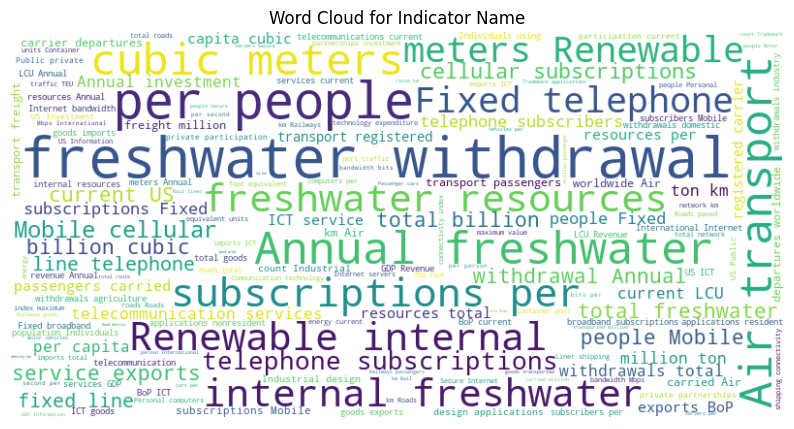

In [374]:

# Join all text in the 'Text_Column' into a single string
text = ' '.join(ocha_clean['Indicator Name'].tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Indicator Name')
plt.show()

## PPRA DATA

PPRA Awarded contracts - Kenya - This dataset shows the tenders awarded to various organizations and the services 

they offered in 2019. We will use this data to train our model in identifying the services a user feels should be 

improved .

In [375]:
#ppra contracts
ppra=pd.read_csv('ke_contracts.csv')
ppra.head()

,id,tender-title,tender-ref_No,contract_amount,contract_code,contract_status,created_at,expected_completion_date,month,org_name,pin_number,supplier_name,tender_award_date,type,updated_at,year
0,0,provision of security services.,NTZDC/TN/03/2018/19/20,"4,852,800.00",MZ4BVH7F,Ongoing,2019-03-11 16:02:26,2019-12-31,Dec,Nyayo Tea Zones Develop Corporation,P051165790I,kleen homes security services limited,2019-12-24,State Corporation,8 Months,2019
1,1,supply and delivery of office safe and bookshe...,KFS/038/2018-2019,"42,000.00",VV12D2BJ,Ongoing,2019-01-30 11:24:19,2019-02-15,Dec,Kenya Forest Service,P051540293F,ample express general supplies,2019-12-24,State Corporation,0 Days,2019
2,2,supply of safety shoes,RFX7702,"40,728.00",R1I9USRQ,Ongoing,2019-01-14 15:25:17,2019-01-04,Dec,Kenya Airport Authority,P051143344Z,zocom limited,2019-12-05,State Corporation,0 Days,2019
3,3,supply and delivery of promotional items,GDC/HQS/RFQ/015/2018-2019,"97,257.00",NMFBVWNJ,Ongoing,2019-02-05 11:39:49,2019-01-28,Dec,Geothermal Development Company,P051546295V,tremit enterprises,2019-12-05,State Corporation,0 Days,2019
4,4,supply and delivery of airtime,EACC/25/2018-2019,"940,000.00",HBI8BFUZ,Ongoing,2019-01-28 15:44:25,2019-01-08,Nov,Ethics and Anti-Corruption Commission,P051129820X,safaricom plc,2019-11-30,Commissions and Independent Offices,0 Days,2019


In [376]:
ppra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4155 entries, 0 to 4154
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        4155 non-null   int64 
 1   tender-title              4155 non-null   object
 2   tender-ref_No             4155 non-null   object
 3   contract_amount           4155 non-null   object
 4   contract_code             4155 non-null   object
 5   contract_status           4155 non-null   object
 6   created_at                4155 non-null   object
 7   expected_completion_date  4155 non-null   object
 8   month                     4155 non-null   object
 9   org_name                  4155 non-null   object
 10  pin_number                4155 non-null   object
 11  supplier_name             4154 non-null   object
 12  tender_award_date         4155 non-null   object
 13  type                      4155 non-null   object
 14  updated_at              

In [377]:
ppra.columns

Index(['id', 'tender-title', 'tender-ref_No', 'contract_amount',
       'contract_code', 'contract_status', 'created_at',
       'expected_completion_date', 'month', 'org_name', 'pin_number',
       'supplier_name', 'tender_award_date', 'type', 'updated_at', 'year'],
      dtype='object')

In [378]:
ppra.head(10)

,id,tender-title,tender-ref_No,contract_amount,contract_code,contract_status,created_at,expected_completion_date,month,org_name,pin_number,supplier_name,tender_award_date,type,updated_at,year
0,0,provision of security services.,NTZDC/TN/03/2018/19/20,"4,852,800.00",MZ4BVH7F,Ongoing,2019-03-11 16:02:26,2019-12-31,Dec,Nyayo Tea Zones Develop Corporation,P051165790I,kleen homes security services limited,2019-12-24,State Corporation,8 Months,2019
1,1,supply and delivery of office safe and bookshe...,KFS/038/2018-2019,"42,000.00",VV12D2BJ,Ongoing,2019-01-30 11:24:19,2019-02-15,Dec,Kenya Forest Service,P051540293F,ample express general supplies,2019-12-24,State Corporation,0 Days,2019
2,2,supply of safety shoes,RFX7702,"40,728.00",R1I9USRQ,Ongoing,2019-01-14 15:25:17,2019-01-04,Dec,Kenya Airport Authority,P051143344Z,zocom limited,2019-12-05,State Corporation,0 Days,2019
3,3,supply and delivery of promotional items,GDC/HQS/RFQ/015/2018-2019,"97,257.00",NMFBVWNJ,Ongoing,2019-02-05 11:39:49,2019-01-28,Dec,Geothermal Development Company,P051546295V,tremit enterprises,2019-12-05,State Corporation,0 Days,2019
4,4,supply and delivery of airtime,EACC/25/2018-2019,"940,000.00",HBI8BFUZ,Ongoing,2019-01-28 15:44:25,2019-01-08,Nov,Ethics and Anti-Corruption Commission,P051129820X,safaricom plc,2019-11-30,Commissions and Independent Offices,0 Days,2019
5,5,supply and delivery of epson receipt printer l...,KFS/028/2018-2019,"127,992.00",UB5FPTEB,Ongoing,2019-01-16 13:09:15,2018-12-24,Nov,Kenya Forest Service,P051456399X,decision analyst limited,2019-11-20,State Corporation,0 Days,2019
6,6,supply and delivery of 51 seater bus(re-tender),TENDER NO. MTRH/T/8/2017-2018,"98,400.00",JQ9F2CLJ,Ongoing,2019-02-07 14:23:15,2019-02-08,Nov,Moi Teaching and Referral Hostipal,P051704983S,sipkelm limited,2019-11-08,State Corporation,0 Days,2019
7,7,supply and delivery of foodstuffs (perishables),TENDER NO. MTRH/T/11/2017-2018,"50,000.00",1EEKWJJL,Ongoing,2019-03-01 10:03:54,2019-02-11,Nov,Moi Teaching and Referral Hostipal,KRAELD5448462018,lalang enterprise solutions limited,2019-11-08,State Corporation,0 Days,2019
8,8,supply and delivery of huma drugs,TENDER NO. MTRH/T/25/2018-2020,"1,148,800.00",6TNHOC0I,Ongoing,2019-03-06 14:54:06,2019-03-04,Nov,Moi Teaching and Referral Hostipal,P051117972H,sai pharmaceuticals limited,2019-11-08,State Corporation,0 Days,2019
9,9,supply and delivery of huma drugs,TENDER NO. MTRH/T/25/2018-2020,"77,800.00",XEDQZ9VI,Ongoing,2019-03-07 14:16:32,1970-01-01,Nov,Moi Teaching and Referral Hostipal,P000599670O,nairobi enterprises limited,2019-11-08,State Corporation,0 Days,2019


In [379]:
#contract awarded per year
counts_per_year=ppra['year'].value_counts()
counts_per_year

year
2018    2871
2019     670
1970     456
2017     125
2016      27
2015       2
1862       2
2014       1
2013       1
Name: count, dtype: int64

In [380]:
ppra['tender-title']

0                         provision of security services.
1       supply and delivery of office safe and bookshe...
2                                  supply of safety shoes
3                supply and delivery of promotional items
4                          supply and delivery of airtime
                              ...                        
4150                    supply and delivery of stationery
4151                    supply and delivery of food stuff
4152                   provision of airticketing services
4153    provision of maintenance services for governme...
4154    provision of maintenance services for governme...
Name: tender-title, Length: 4155, dtype: object

In [381]:
ppra_clean=ppra.copy()

In [382]:
ppra_clean['tender-title']

0                         provision of security services.
1       supply and delivery of office safe and bookshe...
2                                  supply of safety shoes
3                supply and delivery of promotional items
4                          supply and delivery of airtime
                              ...                        
4150                    supply and delivery of stationery
4151                    supply and delivery of food stuff
4152                   provision of airticketing services
4153    provision of maintenance services for governme...
4154    provision of maintenance services for governme...
Name: tender-title, Length: 4155, dtype: object

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


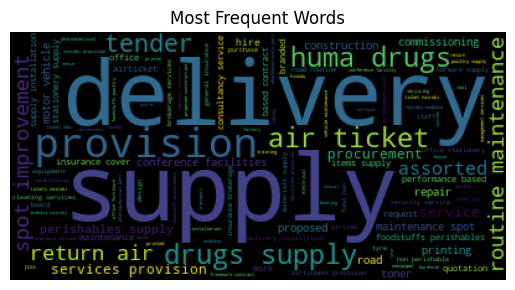

In [383]:
#word cloud
#Remove rows with missing values in 'Indicator Name' column and convert to strings
cleaned_text = ppra_clean['tender-title'].dropna().astype(str)
# Concatenate all texts into a single string
text_combined = ' '.join(cleaned_text)
# Generate a word cloud image
wordcloud = WordCloud().generate(text_combined)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud.recolor(random_state=2017))
plt.title('Most Frequent Words')
plt.axis("off")
plt.show()

## Merging the two datasources

In [384]:

# Merge the columns into a new DataFrame
merged_data = pd.concat([ppra_clean['tender-title'],ocha_clean['Indicator Name'] ], axis=1)

# Rename the columns to 'text'
merged_data.columns = ['text_A', 'text_B']

# Combine text from both columns into a new 'text' column
merged_data['services'] = merged_data['text_A'].fillna('') + merged_data['text_B'].fillna('')

# Drop the individual text columns if needed
merged_data.drop(['text_A', 'text_B'], axis=1, inplace=True)

# Display the resulting DataFrame with merged columns
print(merged_data)

                                               services
0                       provision of security services.
1     supply and delivery of office safe and bookshe...
2     supply of safety shoesICT service exports (BoP...
3     supply and delivery of promotional itemsICT se...
4     supply and delivery of airtimeICT service expo...
...                                                 ...
4150                  supply and delivery of stationery
4151                  supply and delivery of food stuff
4152                 provision of airticketing services
4153  provision of maintenance services for governme...
4154  provision of maintenance services for governme...

[4155 rows x 1 columns]


In [385]:
merged_data

,services
0,provision of security services.
1,supply and delivery of office safe and bookshe...
2,supply of safety shoesICT service exports (BoP...
3,supply and delivery of promotional itemsICT se...
4,supply and delivery of airtimeICT service expo...
...,...
4150,supply and delivery of stationery
4151,supply and delivery of food stuff
4152,provision of airticketing services
4153,provision of maintenance services for governme...


In [386]:
merged_data['services'] = merged_data['services'].apply(preprocess_text)
merged_data['services']

0                             provision security services
1       supply delivery office safe bookshelf chairman...
2       supply safety shoesict service exports bop cur...
3       supply delivery promotional itemsict service e...
4       supply delivery airtimeict service exports bop...
                              ...                        
4150                           supply delivery stationery
4151                           supply delivery food stuff
4152                      provision airticketing services
4153    provision maintenance services government data...
4154    provision maintenance services government data...
Name: services, Length: 4155, dtype: object

In [387]:
# Function to remove duplicates words in a text
def remove_duplicates(text):
    words = text.split()  # Split the text into individual words
    unique_words = []
    
    for word in words:
        if word not in unique_words:
            unique_words.append(word)
            prev_word = word
    
    return ' '.join(unique_words)

In [388]:
merged_data['services'] = merged_data['services'].apply(lambda x: remove_duplicates(str(x)))
merged_data['services'] 

0                             provision security services
1       supply delivery office safe bookshelf chairman...
2       supply safety shoesict service exports bop cur...
3       supply delivery promotional itemsict service e...
4       supply delivery airtimeict service exports bop...
                              ...                        
4150                           supply delivery stationery
4151                           supply delivery food stuff
4152                      provision airticketing services
4153    provision maintenance services government data...
4154    provision maintenance services government data...
Name: services, Length: 4155, dtype: object

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


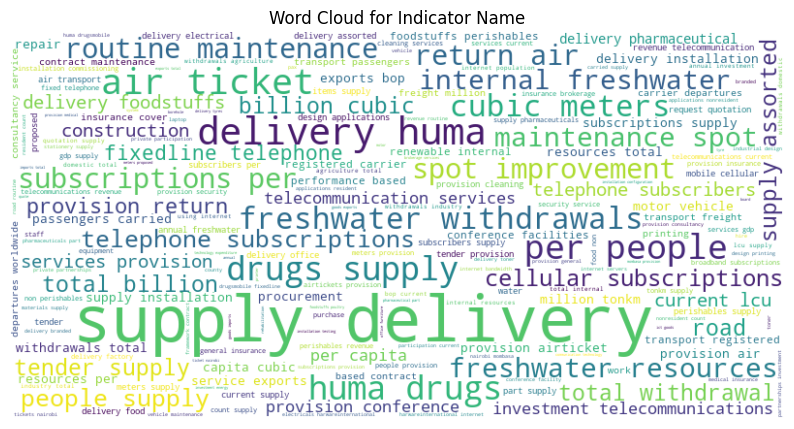

In [389]:

# Join all text in the 'Text_Column' into a single string
text = ' '.join(merged_data['services'].tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Indicator Name')
plt.show()

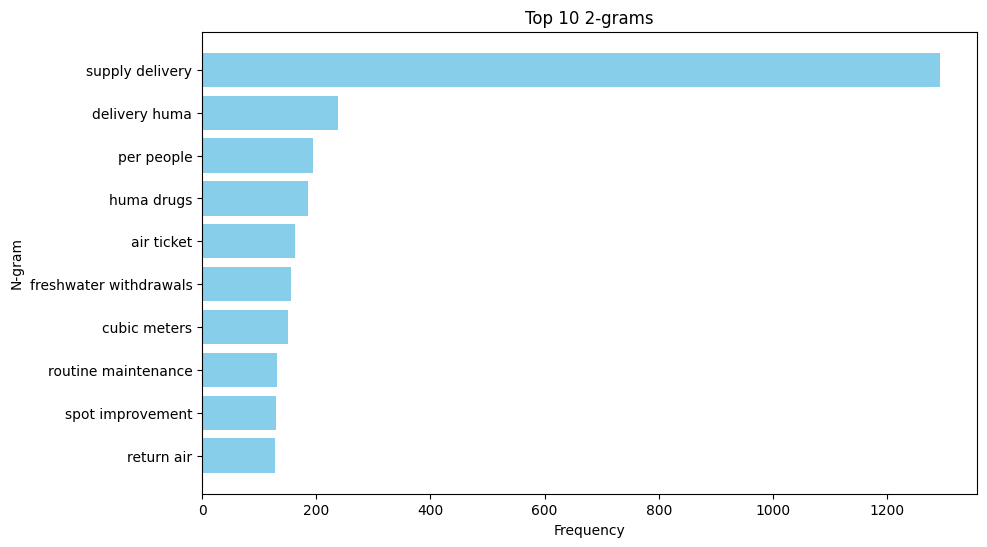

In [390]:
# Function to extract N-grams from text
def extract_ngrams(text, n):
    tokens = word_tokenize(text)  # Tokenize the text
    n_grams = ngrams(tokens, n)  # Generate N-grams
    return [' '.join(gram) for gram in n_grams]  # Join tokens to form N-grams

# Set the value of 'N' for N-grams
N = 2  

# Extract N-grams from the text Series
ngram_list = merged_data['services'].apply(lambda x: extract_ngrams(x, N))

# Flatten the list of lists into a single list of N-grams
flattened_ngrams = [gram for sublist in ngram_list for gram in sublist]

# Use Counter to count the occurrences of each N-gram
ngram_counts = Counter(flattened_ngrams)

# Convert the ngram_counts into a DataFrame for easier plotting
df_ngrams = pd.DataFrame(ngram_counts.items(), columns=['N-gram', 'Frequency'])

# Sort by frequency in descending order
df_ngrams = df_ngrams.sort_values(by='Frequency', ascending=False)

# Plotting the top N-grams
top_n = 10  # Change this value to visualize a different number of top N-grams
plt.figure(figsize=(10, 6))
plt.barh(df_ngrams['N-gram'][:top_n], df_ngrams['Frequency'][:top_n], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('N-gram')
plt.title(f'Top {top_n} {N}-grams')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

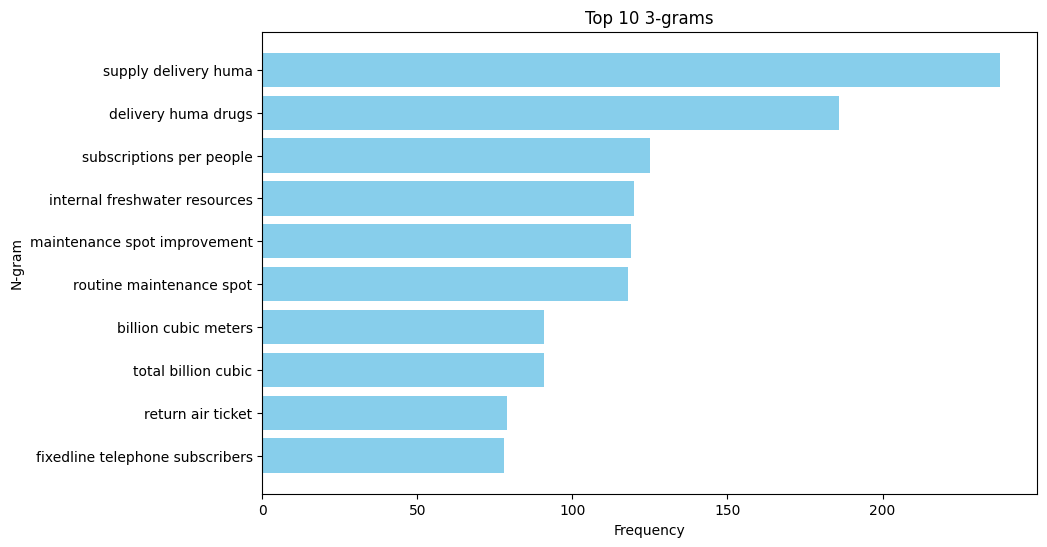

In [391]:
#trigram
# Set the value of 'N' for N-grams
N = 3  

# Extract N-grams from the text Series
ngram_list = merged_data['services'].apply(lambda x: extract_ngrams(x, N))

# Flatten the list of lists into a single list of N-grams
flattened_ngrams = [gram for sublist in ngram_list for gram in sublist]

# Use Counter to count the occurrences of each N-gram
ngram_counts = Counter(flattened_ngrams)

# Convert the ngram_counts into a DataFrame for easier plotting
df_ngrams = pd.DataFrame(ngram_counts.items(), columns=['N-gram', 'Frequency'])

# Sort by frequency in descending order
df_ngrams = df_ngrams.sort_values(by='Frequency', ascending=False)

# Plotting the top N-grams
top_n = 10  # Change this value to visualize a different number of top N-grams
plt.figure(figsize=(10, 6))
plt.barh(df_ngrams['N-gram'][:top_n], df_ngrams['Frequency'][:top_n], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('N-gram')
plt.title(f'Top {top_n} {N}-grams')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

Total number of outliers: 39
Lower bound for outliers: -2.0
Upper bound for outliers: 14.0


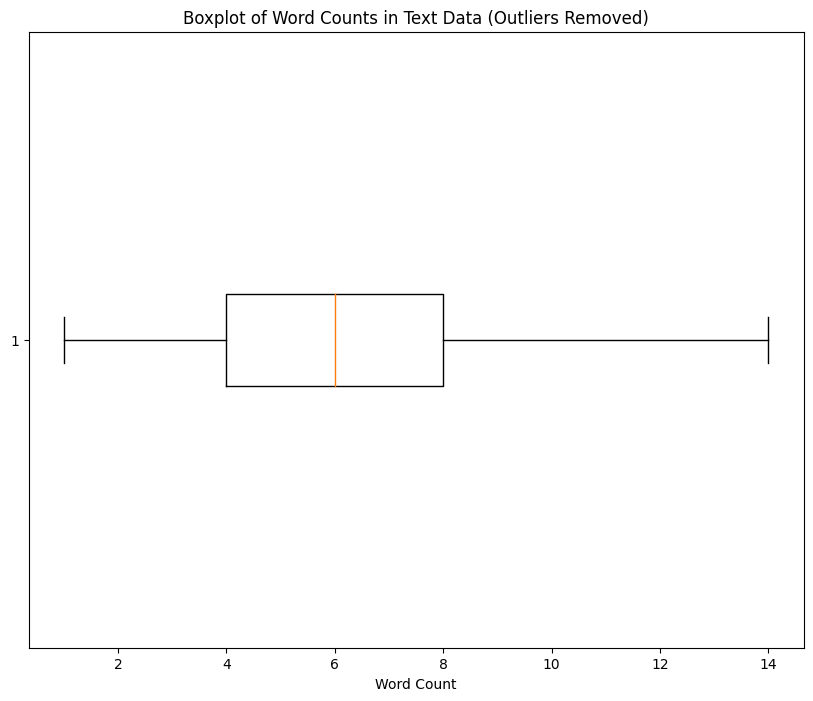

In [392]:
# Let's calculate word counts for each text entry
merged_data['Word_Count']=merged_data['services'].apply(lambda x: len(x.split()))

# Calculating quartiles and IQR
Q1 = merged_data['Word_Count'].quantile(0.25)
Q3 = merged_data['Word_Count'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying outliers
outliers = merged_data[(merged_data['Word_Count'] < lower_bound) | (merged_data['Word_Count'] > upper_bound)]

# Removing outliers from the DataFrame
cleaned_data = merged_data[~((merged_data['Word_Count'] < lower_bound) | (merged_data['Word_Count'] > upper_bound))]

# Displaying information about outliers
print("Total number of outliers:", outliers.shape[0])
print("Lower bound for outliers:", lower_bound)
print("Upper bound for outliers:", upper_bound)

# Visualizing the cleaned data without outliers
plt.figure(figsize=(10, 8))
plt.boxplot(cleaned_data['Word_Count'], vert=False)
plt.xlabel('Word Count')
plt.title('Boxplot of Word Counts in Text Data (Outliers Removed)')
plt.show()


In [393]:
cleaned_data['services']

0                             provision security services
1       supply delivery office safe bookshelf chairman...
2       supply safety shoesict service exports bop cur...
3       supply delivery promotional itemsict service e...
4       supply delivery airtimeict service exports bop...
                              ...                        
4150                           supply delivery stationery
4151                           supply delivery food stuff
4152                      provision airticketing services
4153    provision maintenance services government data...
4154    provision maintenance services government data...
Name: services, Length: 4116, dtype: object

In [394]:
#topic modelling
#tokenize articles
tokeize_article = cleaned_data['services'].apply(lambda x : x.split())
id2word = corpora.Dictionary(tokeize_article)

# Create Corpus
texts = tokeize_article

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

[('provision', 1), ('security', 1), ('services', 1)]

In [395]:
#build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

Tuning hyperparameters:
We can try out different number of topics, different values of alpha and beta(eta) to increse the conharence score. High conherence score is good for our model.

In [396]:
from gensim.models import CoherenceModel
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=n, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha=alpha,
                                                per_word_topics=True,
                                                eta=beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# Example usage to test different hyperparameters
num_topics_list = [5, 10, 15]
alpha_values = ['symmetric', 'asymmetric']
beta_values = ['auto', 0.01, 0.1, 0.5]

best_coherence_score = -1  # Initialize with a low value
best_params = None

for num_topics in num_topics_list:
    for alpha_val in alpha_values:
        for beta_val in beta_values:
            coherence_score = calculate_coherence_score(num_topics, alpha_val, beta_val)
            print(f"Num Topics: {num_topics}, Alpha: {alpha_val}, Beta: {beta_val}, Coherence Score: {coherence_score}")
            
            # Track the best parameters
            if coherence_score > best_coherence_score:
                best_coherence_score = coherence_score
                best_params = {'num_topics': num_topics, 'alpha': alpha_val, 'beta': beta_val}

print(f"Best Coherence Score: {best_coherence_score}")
print("Best Parameters:", best_params)


Num Topics: 5, Alpha: symmetric, Beta: auto, Coherence Score: 0.5700989283408107
Num Topics: 5, Alpha: symmetric, Beta: 0.01, Coherence Score: 0.6147740607606135
Num Topics: 5, Alpha: symmetric, Beta: 0.1, Coherence Score: 0.5528136751318578
Num Topics: 5, Alpha: symmetric, Beta: 0.5, Coherence Score: 0.4617356149667519
Num Topics: 5, Alpha: asymmetric, Beta: auto, Coherence Score: 0.5555952191822542
Num Topics: 5, Alpha: asymmetric, Beta: 0.01, Coherence Score: 0.6041816789940342
Num Topics: 5, Alpha: asymmetric, Beta: 0.1, Coherence Score: 0.5858284288301967
Num Topics: 5, Alpha: asymmetric, Beta: 0.5, Coherence Score: 0.4664911498686156
Num Topics: 10, Alpha: symmetric, Beta: auto, Coherence Score: 0.5841431602851175
Num Topics: 10, Alpha: symmetric, Beta: 0.01, Coherence Score: 0.6508211630332668
Num Topics: 10, Alpha: symmetric, Beta: 0.1, Coherence Score: 0.5841431602851175
Num Topics: 10, Alpha: symmetric, Beta: 0.5, Coherence Score: 0.5326679575971859
Num Topics: 10, Alpha: asy

In [397]:
#Build the LDA model using the best parameters
num_topics = 15
alpha_value = 'symmetric'
beta_value = 'auto'

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=num_topics,
                     alpha=alpha_value,
                     eta=beta_value)

In [398]:
# Print keywords for each topic
topics = lda_model.show_topics(num_topics=15, num_words=10, formatted=False)

for topic_id, words in topics:
    print(f"Topic {topic_id + 1}:")
    keyword_list = [word[0] for word in words]
    print(", ".join(keyword_list))
    print()


Topic 1:
supply, construction, delivery, county, water, sub, pharmaceuticals, materials, installation, proposed

Topic 2:
proposed, health, supply, eastern, provision, services, county, consultancy, shirts, completion

Topic 3:
supply, installation, delivery, commissioning, testing, configuration, secondary, show, stand, ask

Topic 4:
provision, services, cleaning, supply, delivery, house, hospital, upgrading, nyeri, airtickets

Topic 5:
maintenance, supply, fit, airticketing, vehicle, based, transport, performance, contract, delivery

Topic 6:
south, supply, north, sub, package, delivery, training, newspaper, certificates, school

Topic 7:
county, proposed, upgrading, supply, provision, commission, day, ward, services, health

Topic 8:
centre, kenya, maintenance, routine, spot, improvement, kyocera, solar, road, tender

Topic 9:
air, provision, ticket, supply, return, services, laptops, travel, pax, toilet

Topic 10:
supply, delivery, sugar, chemicals, process, branded, drugs, station

In [399]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Convert the Gensim LDA model into a format suitable for pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, id2word)

# Display the visualization
pyLDAvis.display(vis_data)


## k-means 


In [400]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    max_features=8000,
    stop_words='english'
)

# Fit and transform the text data (replace 'text_column' with your column name)
services = tfidf.fit_transform(merged_data['services'])

# Get feature names (words) and their corresponding TF-IDF values
feature_names = tfidf.get_feature_names_out()

# Convert TF-IDF matrix to a DataFrame for better visualization (optional)
tfidf_df = pd.DataFrame(services.toarray(), columns=feature_names)



c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2, the average silhouette score is: 0.0307


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4, the average silhouette score is: 0.0327


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6, the average silhouette score is: 0.0554


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8, the average silhouette score is: 0.0610


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10, the average silhouette score is: 0.0705


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 12, the average silhouette score is: 0.0971


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 14, the average silhouette score is: 0.0928


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 16, the average silhouette score is: 0.0967


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 18, the average silhouette score is: 0.1142


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 20, the average silhouette score is: 0.1174


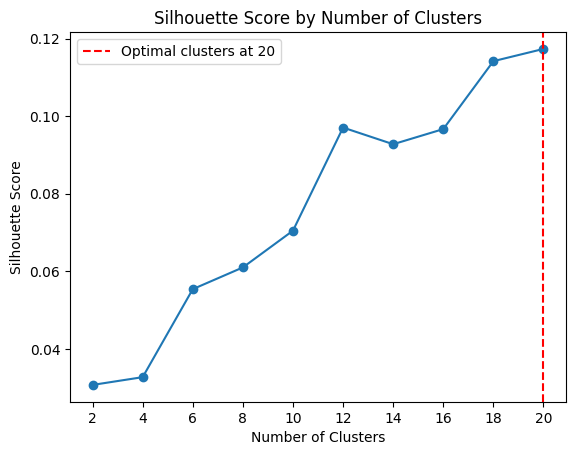

In [401]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k + 1, 2)
    silhouette_scores = []

    for k in iters:
        kmeans = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
        kmeans.fit(data)
        labels = kmeans.predict(data)
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)
        print('For n_clusters = {}, the average silhouette score is: {:.4f}'.format(k, silhouette_avg))

    # Plotting SSE by Cluster Center Plot
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, silhouette_scores, marker='o')
    ax.set_xlabel('Number of Clusters')
    ax.set_xticks(iters)
    ax.set_ylabel('Silhouette Score')
    ax.set_title('Silhouette Score by Number of Clusters')

    # Finding the optimal number of clusters based on the highest silhouette score
    optimal_k = iters[np.argmax(silhouette_scores)]
    ax.axvline(x=optimal_k, linestyle='--', color='red', label='Optimal clusters at {}'.format(optimal_k))
    ax.legend()
    plt.show()


find_optimal_clusters(services, 20)


In [402]:
clusters = MiniBatchKMeans(n_clusters=20, init_size=1024, batch_size=2048, random_state=20).fit_predict(services)

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


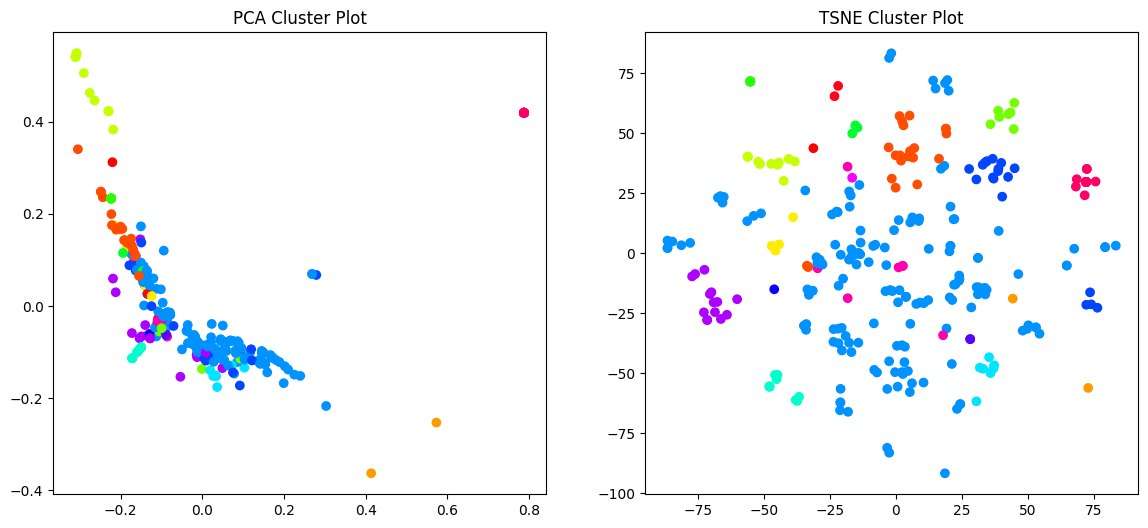

In [403]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import cm

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    # Convert data to a NumPy array
    data_array = np.asarray(data[max_items,:].todense())
    
    pca = PCA(n_components=2).fit_transform(data_array)
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data_array))
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')


# Call the function with your data and labels
plot_tsne_pca(services, clusters)


In [404]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(services, clusters, tfidf.get_feature_names_out(), 10)


Cluster 0
request,quotations,economy,kisumu,mombasa,provision,nairobi,air,return,tickets

Cluster 1
collection,travel,tender,brokerage,insurance,consultancy,cleaning,security,provision,services

Cluster 2
garbage,garissa,gate,gdp,general,generator,furniture,zoology,delivery,supply

Cluster 3
training,procurement,board,naivasha,day,accommodation,facility,provision,facilities,conference

Cluster 4
total,way,nbomsanbo,nairobi,mombasa,pax,provision,return,air,ticket

Cluster 5
drugsmobile,reagents,human,chemicals,supply,delivery,mobile,people,subscriptions,cellular

Cluster 6
garissa,gate,gdp,general,furniture,zoology,return,nairobi,provision,airtickets

Cluster 7
office,servicesair,provision,passengerkm,supply,delivery,air,transport,passengers,carried

Cluster 8
garissa,gate,gdp,general,generator,furniture,zoology,supply,delivery,huma

Cluster 9
roa,annual,investment,revenue,telecommunications,road,maintenance,improvement,spot,routine

Cluster 10
toners,spares,bearings,parts,delivery,ite

In [405]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(services, clusters)

print(f"The silhouette score is: {silhouette_avg}")

The silhouette score is: 0.1173754963408375


Model Testing

In [406]:
testing_data=pd.read_csv('Kenya_dataset1.csv')
testing_data

,Text,Category,Label
0,Is government gonna be taxed for it's idle lan...,Agriculture,9
1,I agree Gava should not talk of youth entrepre...,"Industry, Trade and Cooperatives",11
2,Huyu ameamua kuharibu barabara smh,Transport,2
3,Hakuna maji,Water and sanitation,6
4,Lack of water,Water and sanitation,6
...,...,...,...
4528,"""I'm attending webinars on water-efficient far...",Agriculture,9
4529,"""The drought has united farmers in our region ...",Agriculture,9
4530,"""I'm advocating for increased awareness of dro...",Agriculture,9
4531,"""The drought is a stark reminder of the import...",Agriculture,9


In [407]:
testing_data['Text']=testing_data['Text'].apply(preprocess_text)

In [408]:
text_test_data=testing_data['Text']

In [409]:
from langdetect import detect

# Function to identify the language of each text sample
def identify_language(text):
    try:
        lang = detect(text)
        return lang
    except:
      # Handle cases where language detection fails  
        return "Unknown"  
    
# Add a new column 'Language' to the DataFrame to store the identified language
testing_data['Language'] = testing_data['Text'].apply(identify_language)

# Separate English and Kiswahili texts based on identified language
english_texts = testing_data[testing_data['Language'] == 'en']
kiswahili_texts = testing_data[testing_data['Language'] == 'sw']









In [410]:
english_texts

,Text,Category,Label,Language
0,government gon taxed idle land watu wapande mi...,Agriculture,9,en
1,agree gava talk youth entrepreneurship without...,"Industry, Trade and Cooperatives",11,en
4,lack water,Water and sanitation,6,en
10,electricity problems,Energy,5,en
11,expensive electricity,Energy,5,en
...,...,...,...,...
4528,attending webinars waterefficient farming tech...,Agriculture,9,en
4529,the drought united farmers region collectively...,Agriculture,9,en
4530,advocating increased awareness drought impact ...,Agriculture,9,en
4531,the drought stark reminder importance conserva...,Agriculture,9,en


In [411]:
# Extract labels for English and Kiswahili texts
english_labels = english_texts['Label']
kiswahili_labels = kiswahili_texts['Label']

# Display English and Kiswahili labels
print("English Texts Labels:")
print(english_labels)

print("\nKiswahili Texts Labels:")
print(kiswahili_labels)


English Texts Labels:
0        9
1       11
4        6
10       5
11       5
        ..
4528     9
4529     9
4530     9
4531     9
4532     9
Name: Label, Length: 3541, dtype: int64

Kiswahili Texts Labels:
2       2
3       6
6       2
9       5
16      5
       ..
4127    9
4128    9
4129    9
4130    9
4131    9
Name: Label, Length: 669, dtype: int64


In [412]:
## Vectorize the preprocessed text data using the trained vectorizer
test_tfidf_data = tfidf.transform(english_texts['Text'])

#Predict labels for the testing data using the trained KMeans model
predicted_labels = kmeans.predict(test_tfidf_data)

# Display the predicted labels for English texts
print("Predicted Labels for English Texts:")
print(predicted_labels)


Predicted Labels for English Texts:
[2 2 2 ... 2 2 2]


In [413]:
true_labels=english_texts['Label']
# Evaluate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

# Evaluate Silhouette Score
# Silhouette score measures how similar an object is to its own cluster compared to other clusters
silhouette = silhouette_score(test_tfidf_data, predicted_labels)
print(f"Silhouette Score: {silhouette}")

# Calculate NMI
nmi = metrics.normalized_mutual_info_score(true_labels, predicted_labels)
print(f"Normalized Mutual Information (NMI): {nmi}")


Adjusted Rand Index (ARI): -0.0077737076772508495


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Silhouette Score: 0.23194860527485228
Normalized Mutual Information (NMI): 0.04222275149633206


c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [414]:
import joblib  # Import joblib

# Save the trained KMeans model
joblib.dump(kmeans, 'kmeans_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [415]:
import joblib  # Import joblib

# Load the trained KMeans model
kmeans = joblib.load('kmeans_model.pkl')

# Load the TF-IDF vectorizer
tfidf = joblib.load('tfidf_vectorizer.pkl')
